In [1]:
import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from albumentations import Compose, ShiftScaleRotate, Resize, CenterCrop, HorizontalFlip, RandomBrightnessContrast
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from torchvision import transforms

In [2]:
label = pd.read_csv('RSNA/labels_1.csv')
label = label[['Image','any']]
dir_data1 = 'RSNA/folder_1/'

label_extra = pd.read_csv('RSNA/labels_23.csv')
label_extra = label_extra[['Image','any']]
dir_data_extra = 'RSNA/folder_2/'


In [3]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into training, validation, and test sets
train_data, temp_data = train_test_split(label, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Get the number of positive samples you need from the extra dataset
needed_positives = len(train_data[train_data['any'] == 0]) - len(train_data[train_data['any'] == 1])
available_positives = len(label_extra[label_extra['any'] == 1])

# Fetch the required positive samples from label_extra
extra_data_positives = label_extra[label_extra['any'] == 1].sample(min(needed_positives, available_positives))

# Combine with the main training data
train_data_combined = pd.concat([train_data, extra_data_positives], ignore_index=True)
train_data_combined = train_data_combined.sample(frac=1).reset_index(drop=True)


In [4]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir1, root_dir2, transform=None):
        self.labels = dataframe
        self.root_dir1 = root_dir1
        self.root_dir2 = root_dir2
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir1, self.labels.iloc[idx, 0] + '.png')
        
        # If image not in dir_data1, fetch from dir_data_extra
        if not os.path.exists(img_name):
            img_name = os.path.join(self.root_dir2, self.labels.iloc[idx, 0] + '.png')

        image = Image.open(img_name)
        label = int(self.labels.iloc[idx, 1])

        if self.transform:
            image_np = np.array(image)
            augmented = self.transform(image=image_np)
            image = augmented['image']

        return image, label


# Transformations using albumentations
data_transforms = {
    'train': albu.Compose([
        albu.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333), p=1.0),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.Rotate(limit=20),  # Random rotation between -20 and 20 degrees
        albu.GaussianBlur(p=0.3),
        albu.HueSaturationValue(p=0.3),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'val': albu.Compose([
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'test': albu.Compose([   # Generally, you don't augment test data. Just resize and normalize.
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
}



In [5]:
# Splitting data and creating DataLoaders
train_dataset = CustomDataset(dataframe=train_data_combined, root_dir1=dir_data1, root_dir2=dir_data_extra, transform=data_transforms['train'])
val_dataset = CustomDataset(dataframe=val_data, root_dir1=dir_data1, root_dir2=dir_data_extra, transform=data_transforms['val'])
test_dataset = CustomDataset(dataframe=test_data, root_dir1=dir_data1, root_dir2=dir_data_extra, transform=data_transforms['test'])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'valid': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

print(f"Number of train images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of train images: 90191
Number of validation images: 12363
Number of test images: 12364


In [6]:
from collections import Counter

def label_distribution(dataset):
    return Counter(dataset.labels.iloc[:, 1])

train_label_dist = label_distribution(train_dataset)
val_label_dist = label_distribution(val_dataset)
test_label_dist = label_distribution(test_dataset)

print("Train Label Distribution:")
for label, count in train_label_dist.items():
    print(f"Label {label}: {count} images")

print("\nValidation Label Distribution:")
for label, count in val_label_dist.items():
    print(f"Label {label}: {count} images")

print("\nTest Label Distribution:")
for label, count in test_label_dist.items():
    print(f"Label {label}: {count} images")


Train Label Distribution:
Label 1: 43884 images
Label 0: 46307 images

Validation Label Distribution:
Label 0: 9958 images
Label 1: 2405 images

Test Label Distribution:
Label 0: 9885 images
Label 1: 2479 images


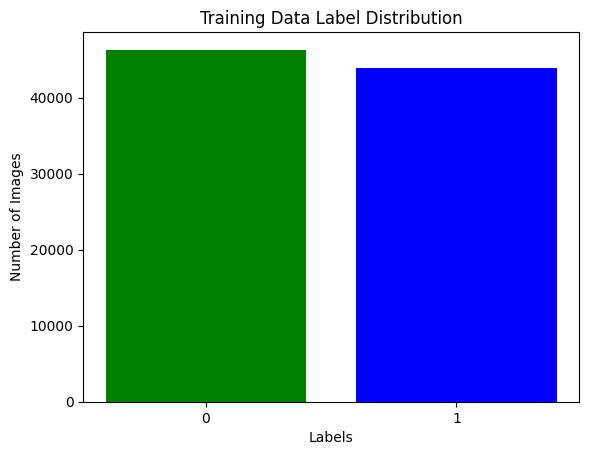

In [7]:
import matplotlib.pyplot as plt

def plot_label_distribution(dist, title):
    labels = list(dist.keys())
    counts = list(dist.values())
    
    plt.bar(labels, counts, color=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])  # Colors can be modified
    plt.xlabel('Labels')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(labels)
    plt.show()

# Plotting the distributions
plot_label_distribution(train_label_dist, 'Training Data Label Distribution')
# plot_label_distribution(val_label_dist, 'Validation Data Label Distribution')
# plot_label_distribution(test_label_dist, 'Test Data Label Distribution')


Training Images:


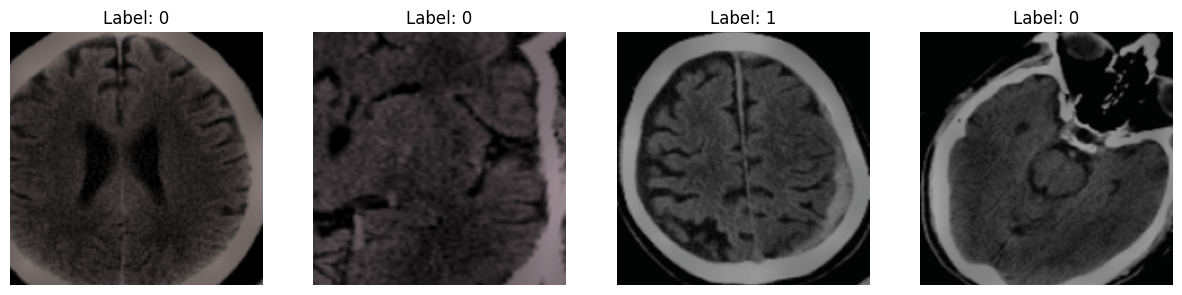

In [8]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

print("Training Images:")
visualize_random_images(dataloaders['train'])

# # Visualize random images from validation dataset
# print("Validation Images:")
# visualize_random_images(dataloaders['valid'])

# # Visualize random images from test dataset
# print("Testing Images:")
# visualize_random_images(dataloaders['test'])

In [9]:
from transformers import AutoConfig, AutoModel


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Load configuration and model
config = AutoConfig.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\brain_tumor_classification')
model = AutoModel.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\brain_tumor_classification', config=config)

for param in model.parameters():
    param.requires_grad = False

model

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


SwinModel(
  (embeddings): SwinEmbeddings(
    (patch_embeddings): SwinPatchEmbeddings(
      (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): SwinEncoder(
    (layers): ModuleList(
      (0): SwinStage(
        (blocks): ModuleList(
          (0-1): 2 x SwinLayer(
            (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attention): SwinAttention(
              (self): SwinSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=128, out_features=128, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): SwinSelfOutput(
                (dense): Linear(in_features=128, out_features=128, bias=T

In [20]:
from torchvision import models
from torch import nn

# Assuming you've loaded your Swin transformer model as "model"
class ModifiedSwinModel(nn.Module):
    def __init__(self, swin_model):
        super(ModifiedSwinModel, self).__init__()
        self.swin_model = swin_model
        self.classifier = nn.Linear(1024, 2)  # Assuming 1024 is the embedding size

    def forward(self, x):
        swin_outputs = self.swin_model(pixel_values=x)  # this gives you SwinModelOutput
        # Extract the appropriate tensor. Assuming pooler_output is what you want:
        x = swin_outputs.pooler_output
        x = self.classifier(x)
        return x





# Freeze the original Swin model parameters
for param in model.parameters():
    param.requires_grad = False

# Initialize the modified model
modified_model = ModifiedSwinModel(model).to(device)



In [21]:
from torchinfo import summary

summary(modified_model)

Layer (type:depth-idx)                                            Param #
ModifiedSwinModel                                                 --
├─SwinModel: 1-1                                                  --
│    └─SwinEmbeddings: 2-1                                        --
│    │    └─SwinPatchEmbeddings: 3-1                              (6,272)
│    │    └─LayerNorm: 3-2                                        (256)
│    │    └─Dropout: 3-3                                          --
│    └─SwinEncoder: 2-2                                           --
│    │    └─ModuleList: 3-4                                       (86,734,648)
│    └─LayerNorm: 2-3                                             (2,048)
│    └─AdaptiveAvgPool1d: 2-4                                     --
├─Linear: 1-2                                                     2,050
Total params: 86,745,274
Trainable params: 2,050
Non-trainable params: 86,743,224

In [22]:
import time
import copy
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 1
    best_loss = float('inf') 
    no_improve = 0 
    early_stop = False

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset),
        'test': len(test_dataset)
    }

    model.to(device)

    for epoch in range(num_epochs):
        if epoch % 5 == 0:
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
                progress_bar = tqdm(dataloaders[phase], desc='Training', leave=False)
            else:
                model.eval()
                progress_bar = tqdm(dataloaders[phase], desc='Validation', leave=False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    progress_bar.set_postfix({'loss': '{:.4f}'.format(loss.item()), 'epoch': epoch+1})

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'valid' and epoch % 5 == 0:
                print('{} Loss at epoch {}: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch + 1, epoch_loss, epoch_acc))

            if phase == 'valid':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch
                    no_improve = 0
                    torch.save(model.state_dict(), 'RSNA_SwinModel_Tumor_pratrained.pth')
                else:
                    no_improve += 1

                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch + 1}. Best epoch was {best_epoch + 1} with best valid accuracy of {best_acc:.4f}.")
                    early_stop = True
                    break

            progress_bar.close()

        if early_stop:
            break

        scheduler.step()

    time_elapsed = time.time() - since

    if (epoch + 1) % 5 == 0:
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best valid accuracy: {:4f} achieved at epoch {}'.format(best_acc, best_epoch + 1))

    model.load_state_dict(best_model_wts)

    # Evaluate the model on test data
    model.eval()
    running_corrects = 0
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    test_acc = running_corrects.double() / dataset_sizes['test']
    print('Test Accuracy: {:4f}'.format(test_acc))

    return model, history


In [24]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(modified_model.classifier.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(modified_model, criterion, optimizer, scheduler, num_epochs=200, patience=5)


Epoch 1/200
----------


valid Loss at epoch 1: 0.3555 Acc: 0.8508


Epoch 6/200
----------


valid Loss at epoch 6: 0.3197 Acc: 0.8720


Early stopping at epoch 9. Best epoch was 4 with best valid accuracy of 0.8765.
Test Accuracy: 0.878437


In [25]:
# # Load the saved model weights
# model_path = 'best_model_weights.pth'
# model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode
# Initialize the prediction and label lists
predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for inputs, classes in dataloaders['valid']:  # Use 'val' instead of 'valid'
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist = torch.cat([predlist, preds.view(-1).cpu()])
        lbllist = torch.cat([lbllist, classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report = classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)

Confusion Matrix
----------------
[[9211  747]
 [ 780 1625]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      9958
           1       0.69      0.68      0.68      2405

    accuracy                           0.88     12363
   macro avg       0.80      0.80      0.80     12363
weighted avg       0.88      0.88      0.88     12363



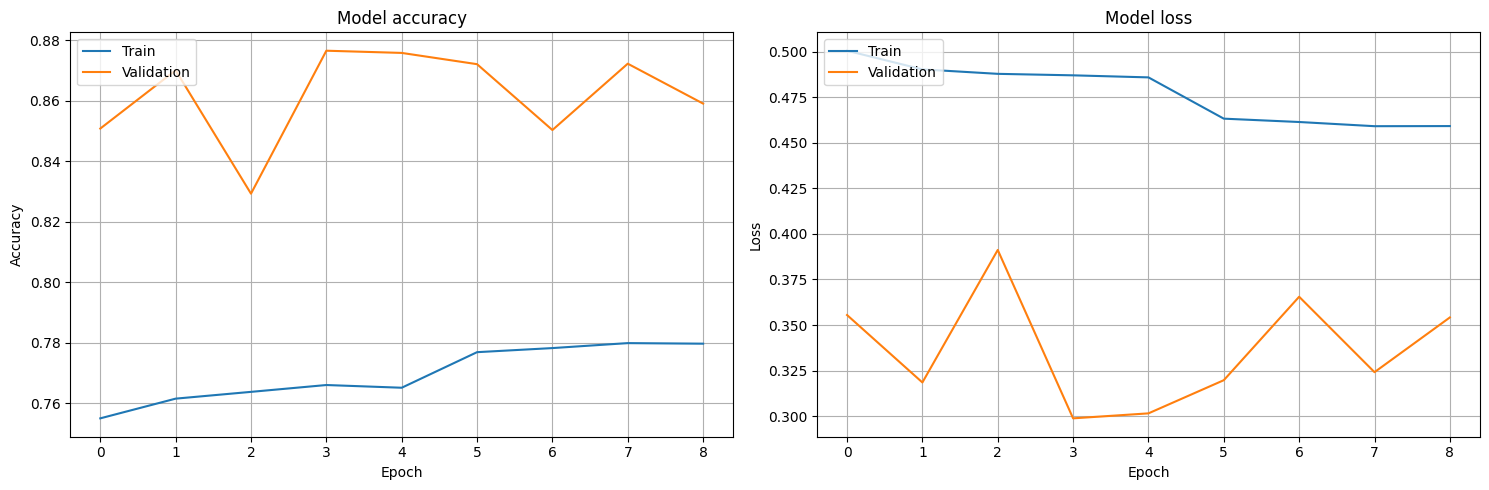

In [26]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # plot training, validation, and testing accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    if 'test_acc' in history:
        ax1.plot(history['test_acc'], label='Test')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training, validation, and testing loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    if 'test_loss' in history:
        ax2.plot(history['test_loss'], label='Test')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


plot_training_history(history)

In [27]:
# Convert the history dictionary to a Pandas DataFrame
history_df = pd.DataFrame(history)

# Save the DataFrame to a CSV file
history_df.to_csv('RSNA_SwinModel_Tumor_pratrained.csv', index=False)

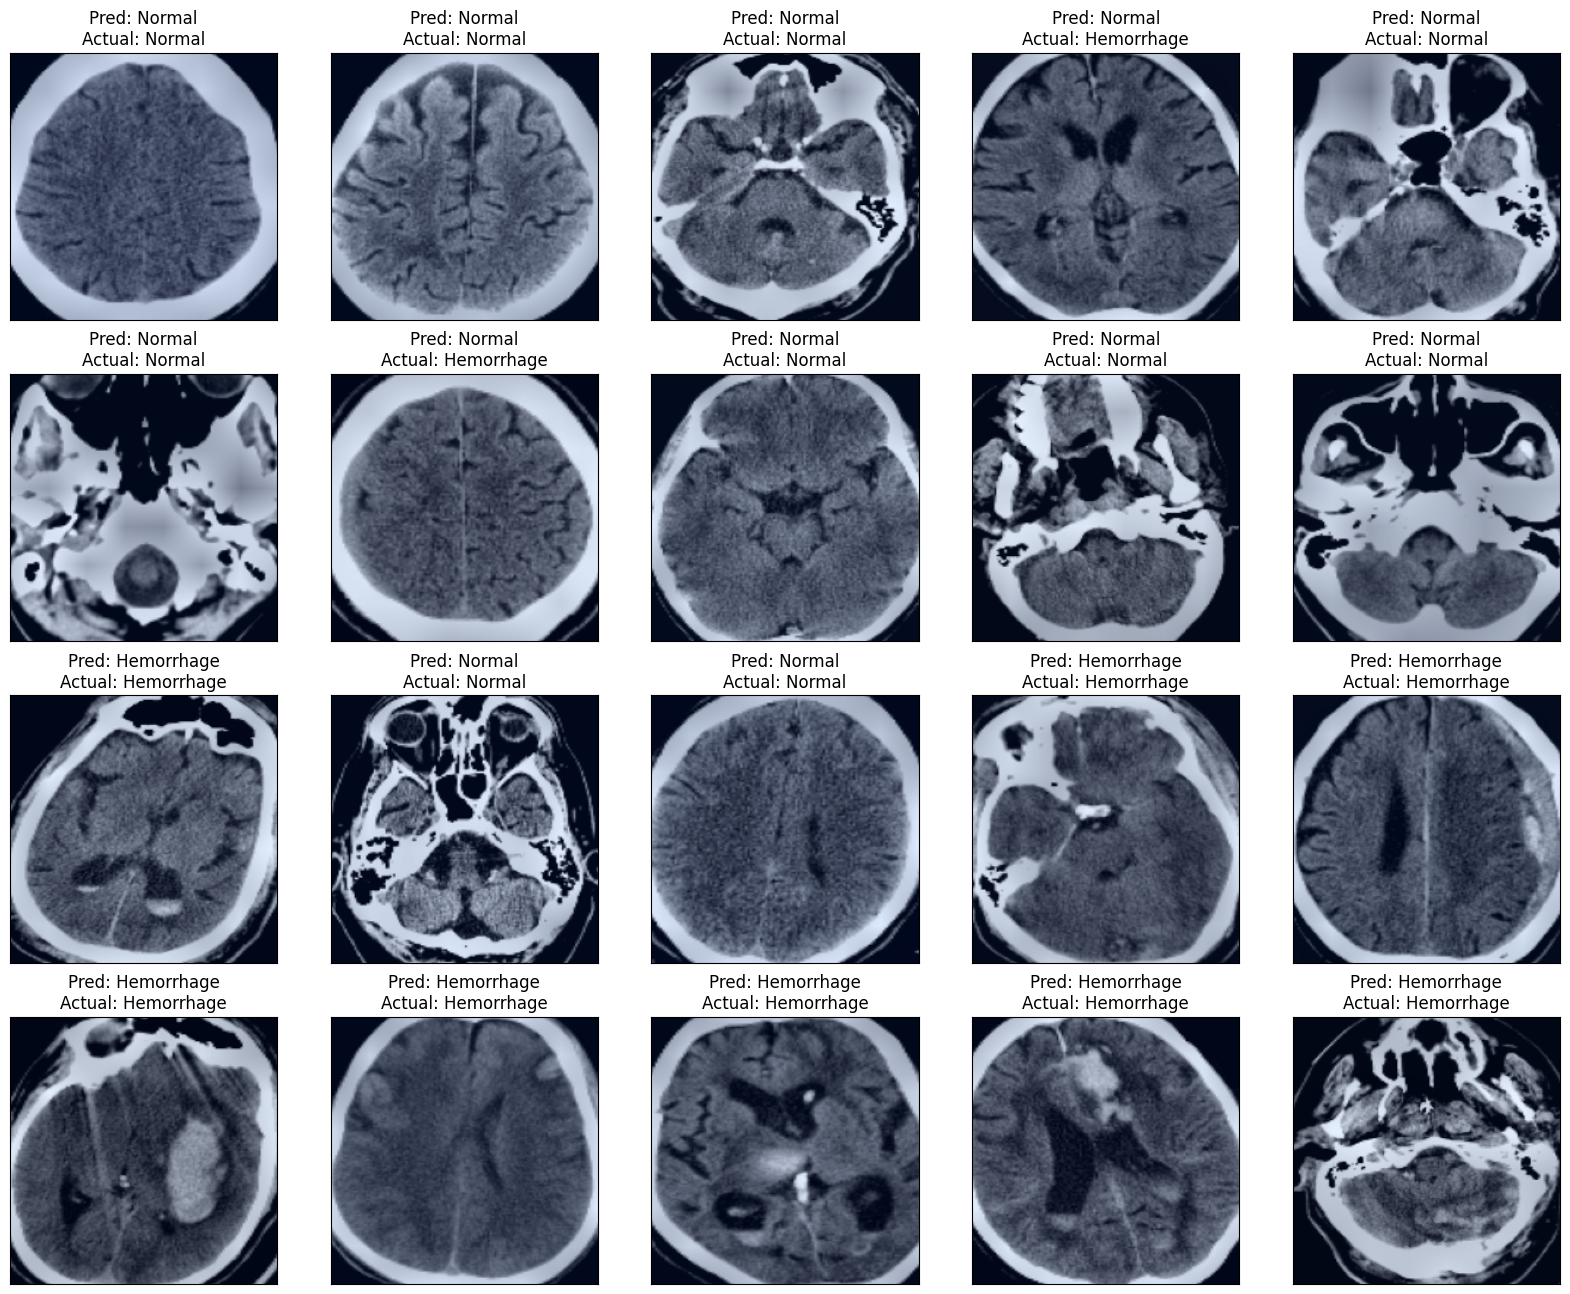

In [29]:
def display_predictions(model, dataloader, num_images=20):
    # Ensure num_images is even for equal representation
    assert num_images % 2 == 0, "Please provide an even number for num_images."
    
    half_num = num_images // 2
    count_class0 = 0
    count_class1 = 0
    
    images_list, labels_list = [], []
    
    for images, labels in dataloader:
        for i in range(len(labels)):
            if labels[i] == 0 and count_class0 < half_num:
                images_list.append(images[i])
                labels_list.append(labels[i])
                count_class0 += 1
            elif labels[i] == 1 and count_class1 < half_num:
                images_list.append(images[i])
                labels_list.append(labels[i])
                count_class1 += 1
        
        # Exit loop once required images from both classes are collected
        if count_class0 >= half_num and count_class1 >= half_num:
            break

    images = torch.stack(images_list)[:num_images]
    labels = torch.tensor(labels_list)[:num_images]
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Map the class indices to their respective labels
    class_names = ['Normal', 'Hemorrhage']
    
    # Plot the images with their predictions and actual labels
    fig = plt.figure(figsize=(20, 4 * (num_images // 5)))
    for i in range(num_images):
        ax = fig.add_subplot(num_images // 5, 5, i+1, xticks=[], yticks=[])
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  # Denormalize
        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}")

# Display predictions
display_predictions(model, dataloaders['test'])


In [30]:
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt

def crop_brain(image, threshold=10):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold only
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Find the contours of the binary image
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box coordinates
    crop = image[y:y+h, x:x+w]
    
    return crop

# Define the custom Albumentations transform
class BrainCrop(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        
    def apply(self, image, **params):
        return crop_brain(image)

class CLAHE(A.ImageOnlyTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8), always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        
    def apply(self, image, **params):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img_clahe = clahe.apply(gray)
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2BGR)
        return img_clahe

# Define the transform pipeline
primal_transform = A.Compose([
    BrainCrop(),
    A.Resize(256, 256),  # Resize the cropped image
    CLAHE()  # Apply CLAHE filter
])


The predicted class for the image is: Hemorrhage
Probabilities for each class:
Normal: 2.30%
Hemorrhage: 97.70%


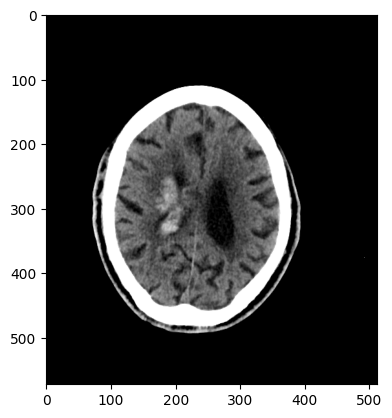

In [36]:
import torch.nn.functional as F

def predict_image_class_with_probabilities(model, image_path, transform, primal_transform):
    """
    Predict the class of an image and return the probabilities for each class.

    Parameters:
    - model: Trained PyTorch model.
    - image_path: Path to the image file (JPG or PNG).
    - transform: Image transformations to apply before prediction.

    Returns:
    - predicted_class: Predicted class label.
    - class_probabilities: Probabilities for each class.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)


    # Convert the PIL image to a numpy array
    image_np = np.array(image)

    image_np = primal_transform(image=image_np)["image"]

    
    # Apply the transformations using the named argument
    augmented = transform(image=image_np)
    image_tensor = augmented['image'].unsqueeze(0).to(device)  # The 'image' key contains the transformed image tensor
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)[0] * 100  # Convert to percentages
        _, predicted_idx = torch.max(output, 1)
    
    # Map the class indices to their respective labels
    class_names = ['Normal', 'Hemorrhage']  # Replace with your class names
    predicted_class = class_names[predicted_idx.item()]
    
    class_probabilities = {class_name: prob.item() for class_name, prob in zip(class_names, probabilities)}
    
    return predicted_class, class_probabilities


# Example usage
image_path = r"Test/slice_19.png"
image = Image.open(image_path)

predicted_class, class_probabilities = predict_image_class_with_probabilities(model, image_path, data_transforms['val'], primal_transform)
print(f"The predicted class for the image is: {predicted_class}")
print("Probabilities for each class:")
for class_name, prob in class_probabilities.items():
    print(f"{class_name}: {prob:.2f}%")
